#### Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

#### Path

In [2]:
data_path = r'tested_molecules.csv'

#### Load data

In [3]:
df = pd.read_csv(data_path)

# Check if there is any missing data and duplicated rows
missing_count = df.isnull().sum()
print("Number of missing values in each column:\n", missing_count)
any_missing_values = df.isnull().values.any()
print("Are there any missing values in the DataFrame?",any_missing_values)

# Check for infinite values
inf_values = df.isin([np.inf, -np.inf]).sum()
print("Number of infinite values in each column:")
print(inf_values)

# Count the number of duplicated rows
duplicate_count = df.duplicated().sum()
print("Number of duplicated rows:", duplicate_count)

# Check which rows only contain one value
single_value_columns = df.columns[df.nunique() == 1]
print("Column containing only one value:", single_value_columns)
# Remove the columns with only one unique value from the DataFrame
df = df.drop(columns=single_value_columns)

# Create dataframes for SMILES, PKM2 and ERK2
smiles = df['SMILES']
PKM2_inhibition = df['PKM2_inhibition']
ERK2_inhibition = df['ERK2_inhibition']
data = df.iloc[:, 3::]

# Create the labels DataFrame
labels = pd.DataFrame(index=df.index, columns=['labels'])
# Assign labels based on conditions
labels['Class'] = df['PKM2_inhibition'] + 2 * df['ERK2_inhibition']
# Class labels
class_labels = {
    0: 'None',
    1: 'PKM2',
    2: 'ERK2',
    3: 'PKM2 and ERK2',
}

Number of missing values in each column:
 SMILES               0
PKM2_inhibition      0
ERK2_inhibition      0
MaxAbsEStateIndex    0
MaxEStateIndex       0
                    ..
fr_thiazole          0
fr_thiocyan          0
fr_thiophene         0
fr_unbrch_alkane     0
fr_urea              0
Length: 213, dtype: int64
Are there any missing values in the DataFrame? False
Number of infinite values in each column:
SMILES               0
PKM2_inhibition      0
ERK2_inhibition      0
MaxAbsEStateIndex    0
MaxEStateIndex       0
                    ..
fr_thiazole          0
fr_thiocyan          0
fr_thiophene         0
fr_unbrch_alkane     0
fr_urea              0
Length: 213, dtype: int64
Number of duplicated rows: 0
Column containing only one value: Index(['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'EState_VSA11',
       'fr_HOCCN', 'fr_SH', 'fr_aldehyde', 'fr_azide', 'fr_azo',
       'fr_benzodiazepine', 'fr_diazo', 'fr_epoxide', 'fr_hdrzine',
       'fr_hdrzone', 'fr_isocyan', 'f

### Distribution of data

#### Correlation data

Total correlated variable pairs (correlation > 0.95): 74


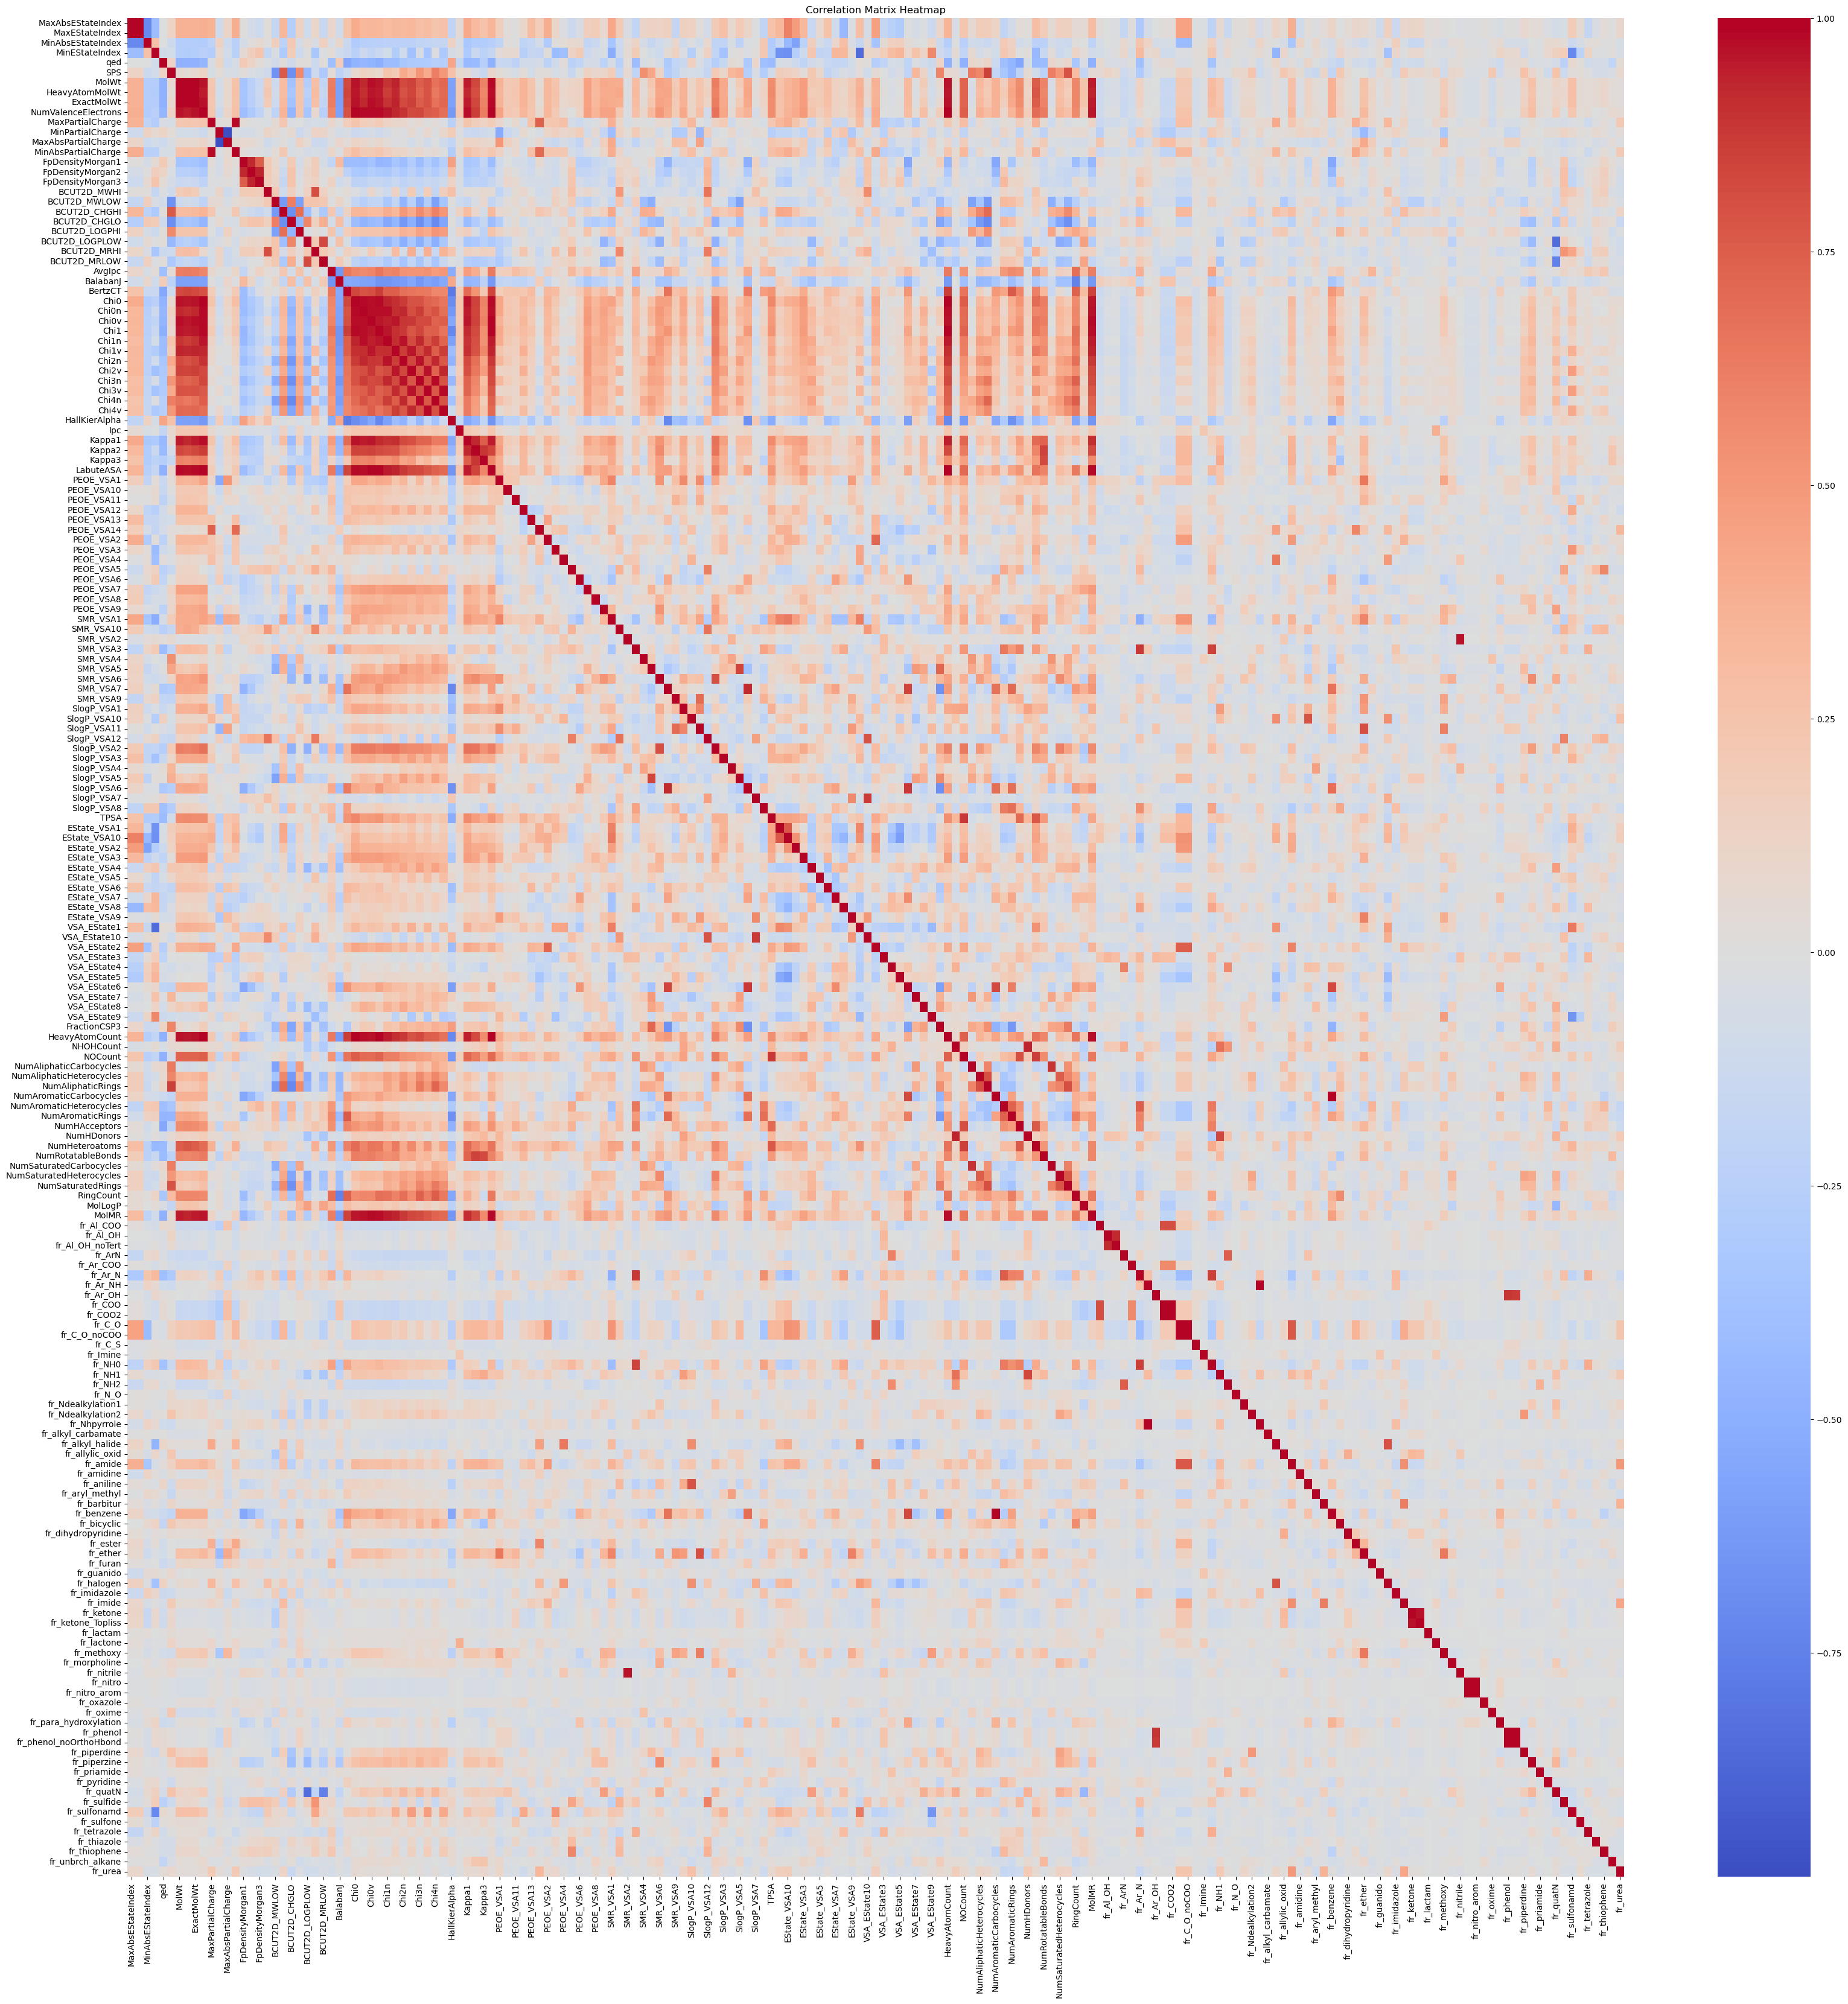

In [4]:
# Compute the correlation matrix
correlation_matrix = data.corr()

# Threshold correlation
correlation_value = 0.95
# Create a mask for correlations greater than the threhold
highly_correlated_mask = np.abs(correlation_matrix) > correlation_value
# Set the diagonal values to FALSE
np.fill_diagonal(highly_correlated_mask.values, False)
# Extract the upper triangle of the correlation matrix
upper_triangle_mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
# Apply the upper triangle mask to the highly correlated mask
highly_correlated_upper = highly_correlated_mask & upper_triangle_mask
# Count the number of highly correlated pairs
highly_correlated_count = highly_correlated_upper.sum()

print(f"Total correlated variable pairs (correlation > {correlation_value}):", highly_correlated_count.sum())

# Generate a heatmap
plt.figure(figsize=(40,40))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

#### Visualization distribution features

In [5]:
df_melted = data.melt(var_name='Feature', value_name='Value')

# Create the boxplot
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='Feature', y='Value', data=df_melted)
# plt.title('Boxplot of Features')
# plt.xlabel('Feature')
# plt.ylabel('Value')
# plt.show()

# Create histograms
# g = sns.FacetGrid(df_melted, col='Feature', col_wrap=5, sharex=False, sharey=False)
# g.map(plt.hist, 'Value', bins=20)
# g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle('Histograms of Features')
# plt.show()

# Create density plots
# g = sns.FacetGrid(df_melted, col='Feature', col_wrap=5, sharex=False, sharey=False)
# g.map(sns.kdeplot, 'Value')
# g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle('Density Plots of Features')
# plt.show()

### Principal Component Analysis

In [6]:
# Scales data between 0 and 1
minmax_scaler = MinMaxScaler()

minmax_data = minmax_scaler.fit_transform(data)

# Initialize the 2D PCA
pca = PCA(n_components=2)

# Applies SVD to find the features with the most variance
data_pca = pca.fit_transform(minmax_data)

#### All molecules

##### Scree plot

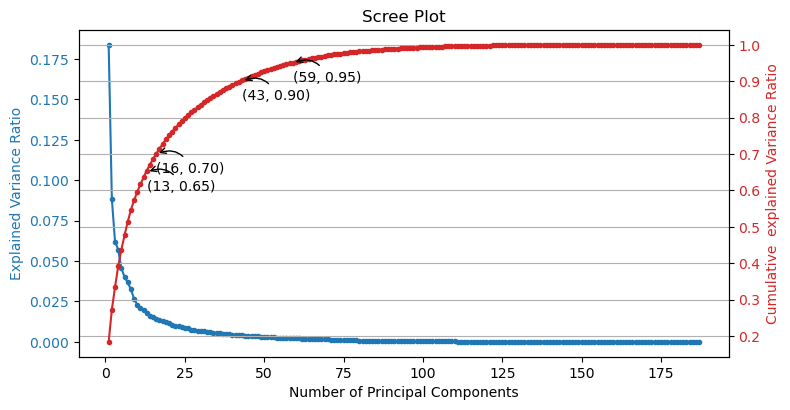

In [7]:
n_features = data.shape[1]
pca_features = PCA(n_components=n_features)
pca_features.fit(minmax_data)

# Calculate explained variance ratio
explained_variance_ratio = pca_features.explained_variance_ratio_

fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot the EVR of each component (feature)
color = 'tab:blue'
ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Explained Variance Ratio', color=color)
ax1.plot(np.arange(1, n_features+1), explained_variance_ratio, marker='.', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Plot the cumulative EVR of each component
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Cumulative  explained Variance Ratio', color=color)
ax2.plot(np.arange(1, n_features+1), np.cumsum(explained_variance_ratio), marker='.', linestyle='-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add annotations for specific points
thresholds = [0.65, 0.70, 0.90, 0.95]
for threshold in thresholds:
    index = np.argmax(np.cumsum(explained_variance_ratio) >= threshold)
    plt.annotate(f'({index+1}, {threshold:.2f})',
                 xy=(index+1, threshold),
                 xytext=(index+1, threshold - 0.05),
                 arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='arc3,rad=0.5'))

fig.tight_layout()
plt.title('Scree Plot')
plt.grid(True)
plt.show()

##### Visualization PCA 2D

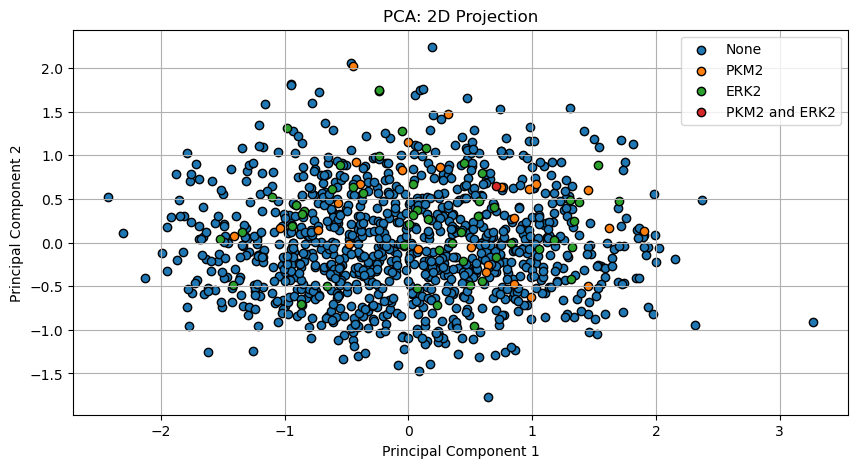

In [8]:
# Plot the PC1 and PC2 with different colors matching the classes
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.scatter(data_pca[labels['Class'] == i, 0], data_pca[labels['Class'] == i, 1], label=class_labels[i], edgecolor='k')
plt.title('PCA: 2D Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

#### Molecules that only contain PKM2 and/or ERK2

In [9]:
# Remove all molecules that do not contain PKM2 and/or ERK2
data_filtered = data[labels['Class'] != 0]
labels_filtered = labels[labels['Class'] != 0]
# Scale data and apply pca
minmax_data_filtered = minmax_scaler.fit_transform(data_filtered)
data_pca_filtered = pca.fit_transform(minmax_data_filtered)

##### Scree plot

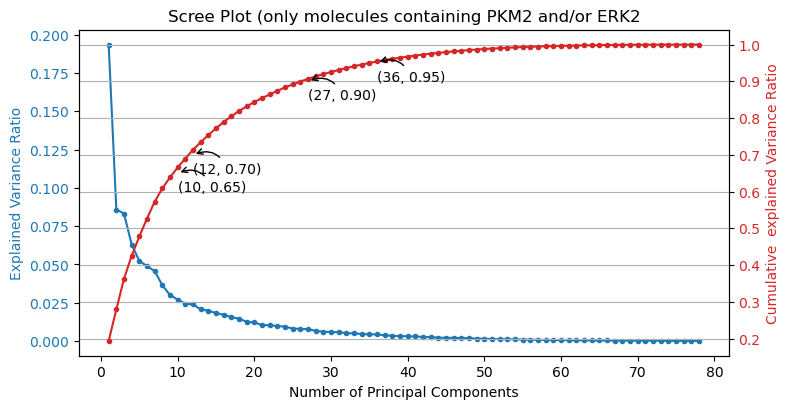

In [10]:
n_features = min(data_filtered.shape[0], data_filtered.shape[1])
pca_features_filtered = PCA(n_components=n_features)
pca_features_filtered.fit(minmax_data_filtered)

# Calculate explained variance ratio
explained_variance_ratio_filtered = pca_features_filtered.explained_variance_ratio_

fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot the EVR of each component (feature)
color = 'tab:blue'
ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Explained Variance Ratio', color=color)
ax1.plot(np.arange(1, n_features+1), explained_variance_ratio_filtered, marker='.', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Plot the cumulative EVR of each component
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Cumulative  explained Variance Ratio', color=color)
ax2.plot(np.arange(1, n_features+1), np.cumsum(explained_variance_ratio_filtered), marker='.', linestyle='-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add annotations for specific points
thresholds = [0.65, 0.70, 0.90, 0.95]
for threshold in thresholds:
    index = np.argmax(np.cumsum(explained_variance_ratio_filtered) >= threshold)
    plt.annotate(f'({index+1}, {threshold:.2f})',
                 xy=(index+1, threshold),
                 xytext=(index+1, threshold - 0.05),
                 arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='arc3,rad=0.5'))

fig.tight_layout()
plt.title('Scree Plot (only molecules containing PKM2 and/or ERK2')
plt.grid(True)
plt.show()


##### Visualization PCA 2D

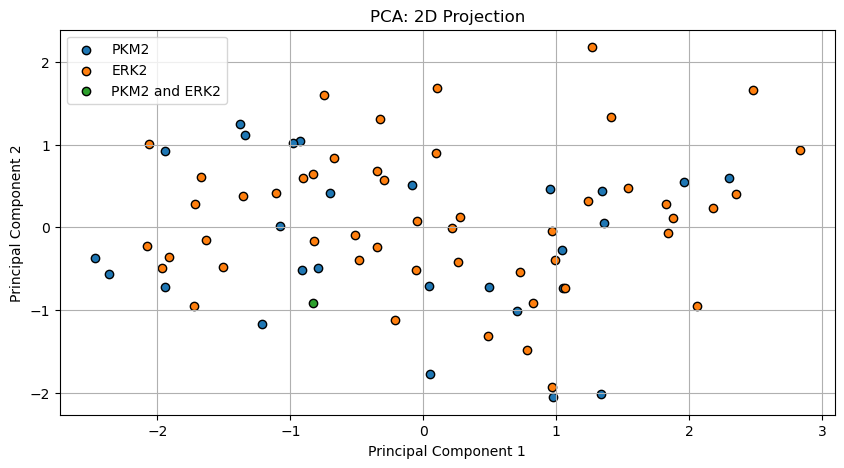

In [11]:
# Plot the PC1 and PC2 with different colors matching the classes
plt.figure(figsize=(10, 5))
for i in range(1,4):
    plt.scatter(data_pca_filtered[labels_filtered['Class'] == i, 0], data_pca_filtered[labels_filtered['Class'] == i, 1], label=class_labels[i], edgecolor='k')
plt.title('PCA: 2D Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

#### Loadings

### TSNE (maybe)